# Import libraries

This is intended as a simple, short introduction to the operations competitors will need to perform with TPUs.

In [ ]:
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.layers import Flatten, Dropout, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import numpy as np
import matplotlib.pyplot as plt

print("Tensorflow version " + tf.__version__)

# Detect my accelerator

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

# Get my data path

In [ ]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started') # you can list the bucket with "!gsutil ls $GCS_DS_PATH"

#  Set some parameters

In [ ]:
IMAGE_SIZE = [512, 512] # at this size, a GPU will run out of memory. Use the TPU
EPOCHS_STEP1 = 50
EPOCHS_STEP2 = 40
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
print("Batch size = ", BATCH_SIZE)

NUM_TRAINING_IMAGES = 12753
NUM_TEST_IMAGES = 7382
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print("Steps per epoch = ", STEPS_PER_EPOCH)

# Load my data

This data is loaded from Kaggle and automatically sharded to maximize parallelization.

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU 
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augmention(image, label):
    images = tf.image.random_flip_left_right(image)
    return images, label

def get_training_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-512x512/train/*.tfrec'), labeled=True)
    dataset = dataset.map(data_augmention, num_parallel_calls = AUTOTUNE)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-512x512/val/*.tfrec'), labeled=True, ordered=False)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-512x512/test/*.tfrec'), labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

# Optimizer learning rate tuning

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 10))

with strategy.scope():        

    local_weights_file = '../input/inception-v3-weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
    pretrained_model = tf.keras.applications.InceptionV3(input_shape = [*IMAGE_SIZE, 3], 
                                include_top = False, 
                                weights = None)

    pretrained_model.load_weights(local_weights_file)

    for layer in pretrained_model.layers:
        layer.trainable = False
    
    last_layer = pretrained_model.get_layer('mixed7')
    print('last layer output shape: ', last_layer.output_shape)
    last_output = last_layer.output

    x = GlobalAveragePooling2D()(last_output)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense  (104, activation='softmax')(x)           
    
    model = tf.keras.Model( pretrained_model.input, x)

model.compile(
    optimizer = RMSprop(learning_rate=1e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

historical = model.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          validation_data=validation_dataset,
            callbacks=[lr_schedule])

plt.semilogx(historical.history["lr"], historical.history["loss"])
plt.axis([1e-5, 1e-2, 0, 5])

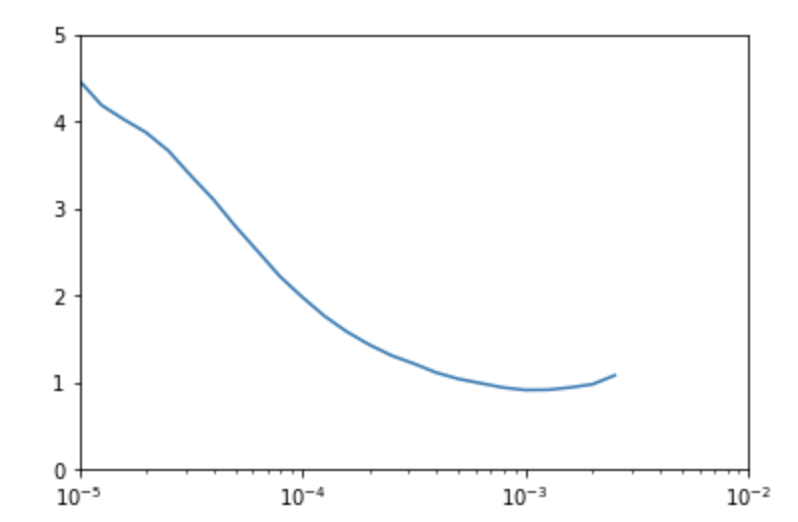

# Build, Compile and fit the model

In [ ]:
with strategy.scope():
    
    pretrained_model = tf.keras.applications.InceptionV3(input_shape = [*IMAGE_SIZE, 3], include_top = False,
                                                     weights='../input/inception-v3-weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

    pretrained_model.trainable = False

#     last_layer = pretrained_model.get_layer('mixed7')
#     last_output = last_layer.output

#     x = data_augmentation()(last_output)
    x = GlobalAveragePooling2D()(pretrained_model.get_layer('mixed7').output)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense  (104, activation='softmax')(x)           

    model = tf.keras.Model( pretrained_model.input, x)

model.compile(
    optimizer = RMSprop(learning_rate=1e-3),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# early_stop = tf.keras.callbacks.EarlyStopping(verbose=1, patience=5, monitor="val_loss", restore_best_weights=True)

historical = model.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS_STEP1,
          validation_data=validation_dataset)

In [ ]:
# plot helper function
def plot_graph(history, string):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    
plot_graph(historical, "sparse_categorical_accuracy")
plot_graph(historical, "loss")
plt.show()

In [ ]:
pretrained_model.trainable = True

model.compile(
    optimizer = RMSprop(learning_rate=1e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

historical = model.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS_STEP2, 
          validation_data=validation_dataset)

In [ ]:
plot_graph(historical, "sparse_categorical_accuracy")
plot_graph(historical, "loss")
plt.show()

# Compute your predictions on the test set!

This will create a file that can be submitted to the competition.

In [ ]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')